In [1]:
import os
import random
import re
import gensim
from gensim import models
from gensim.models import Word2Vec
from gensim import similarities
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pprint
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy import dot
from numpy.linalg import norm
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from networkx.algorithms import community
from operator import itemgetter

/Users/peilingjiang/Documents/cognition_env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Word2vec
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
wv

## Preprocessing

In [4]:
## Cosine similarity
def cosine_similarity(a, b):
    return dot(a, b) / (norm(a) * norm(b))

In [5]:
CONTRACTION_MAP = {
    "ain't": "am not",
    "aren't": "am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(
        contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        #print(match)
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        #print(expanded_contraction)
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [6]:
def remove_stopwords(text):
    stopword_list = set(stopwords.words('english'))

    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]

    filtered_tokens = [token for token in tokens if token not in stopword_list]

    return ' '.join(filtered_tokens)

In [7]:
# Model 20
# m10 = ' '.join(['had', 'proceed', 'vii', 'nants', 'hee', 'she', 'carrier', 'piece', 'over', 'urge', 'guest', 'flash', 'adjustment', 'boy', 'snow', 'lizwe', 'played', 'throne', 'sithi', 'room', 'whisker', 'poacher', 'admonition', 'cape', 'swimming', 'witch', 'road', 'family', 'annoyingly', 'jellyman', 'brat', 'seven', 'haystack', 'bubble', 'going', 'chanting', 'n', 'staircase', 'than', 'much', 'scyphozoa', 'coaxed', 'iv', 'yetits', 'few', 'sought', 'yeah', 'retire', 'minute', 'lily', 'ago', 'in', 'if', 'dude', 'foot', 'ctenophora', 'father', 'ahem', 'overcoming', 'wizard', 'sprat', 'is', 'friend', 'useful', 'marlin', 'back', 'reef', 'wannahockaloogie', 'nemosquirt', 'ground', 'turley', 'funnier', 'recommenced', 'wedded', 'brick', 'impressive', 'guttered', 'john', 'large', 'traveler', 'not', 'face', 'mask', 'speederbike', 'file', 'mason', 'shocking', 'honour', 'motto', 'i', 'vine', 'rabbit', 'chaos', 'custard', 'sneaking', 'railway', 'reach', 'end', 'plankton', 'low', 'messmate', 'down', 'x', 'which', 'pirate', 'up', 'idea', 'who', 'smelt', 'aaaaaaaah', 'but', 'head', 'run', 'oclock', 'fa', 'corner', 'instant', 'dragon', 'gymnastics', 'phrase', 'jetsam', 'matter', 'time', 'gust', 'mirror', 'edge', 'him', 'quacking', 'identical', 'vi', 'desolation', 'field', 'plank', 'art', 'follows', 'look', 'way', 'learning', 'bleu', 'hwee', 'memory', 'doo', 'spooked', 'simba', 'folklore', 'littered', 'ray', 'hare', 'voice', 'must', 'doeuvres', 'stretching', 'same', 'aped', 'aaaaaaaaaaaah', 'crevice', 'excellent', 'bare', 'roger', 'explanation', 'combined', 'child', 'ngo', 'them', 'earliest', 'gate', 'cabinboy', 'coquettish', 'rate', 'mother', 'shrimp', 'douses', 'pursuit', 'cooper', 'dialect', 'la', 'thought', 'zone', 'henry', 'frog', 'january', 'anthozoa', 'he', 'king', 'crisp', 'apana', 'steam', 'library', 'emperor', 'polite', 'style', 'did', 'typhoon', 'fathom', 'footstep', 'moment', 'ledge', 'closeup', 'enormous', 'mind', 'heart', 'gun', 'boisterously', 'parallax', 'encouraging', 'anger', 'switch', 'bird', 'to', 'gratified', 'creature', 'chickenhearted', 'provokingly', 'stone', 'nipped', 'fishy', 'worm', 'canal', 'passably', 'onethe', 'dear', 'tagging', 'cap', 'log', 'orca', 'cricket', 'apple', 'xvi', 'entry', 'got', 'offspring', 'his', 'panoramic', 'xolo', 'pov', 'soup', 'po', 'could', 'kid', 'shark', 'cage', 'pungent', 'prepared', 'crony', 'ballantyne', 'ho', 'potts', 'city', 'hun', 'stealthy', 'grimacing', 'em', 'marooners', 'doggy', 'verse', 'can', 'lion', 'they', 'our', 'seadog', 'ow', 'aaaaaaaaaah', 'pond', 'wallaby', 'ariel', 'into', 'li', 'deal', 'securely', 'soldier', 'extended', 'course', 'scene', 'drooping', 'hydrozoa', 'swimmer', 'for', 'fawn', 'what', 'oz', 'wish', 'bagithi', 'leader', 'green', 'relish', 'xiv', 'hand', 'unwinding', 'majesty', 'nemo', 'other', 'arrow', 'zuzzy', 'hup', 'here', 'be', 'woodman', 'imaginary', 'benbow', 'ha', 'your', 'zu', 'dread', 'elephant', 'smooth', 'soon', 'begirt', 'reedsthe', 'reflected', 'd', 'scarecrow', 'bench', 'crediting', 'bit', 'chocolate', 'oui', 'good', 'withered', 'reassuringly', 'astonishment', 'mastera', 'steamengine', 'redruth', 'murmuring', 'belle', 'meerkat', 'pinked', 'spider', 'monotone', 'fatally', 'guppy', 'thando', 'roof', 'le', 'pan', 'waistcoat', 'a', 'will', 'house', 'air', 'dominion', 'longer', 'drill', 'then', 'desired', 'monkey', 'you', 'sprawling', 'tank', 'saw', 'were', 'essence', 'sorry', 'eye', 'solitary', 'fillin', 'marble', 'sherman', 'alors', 'sha', 'granted', 'grass', 't', 'france', 'regains', 'shoe', 'coinciding', 'chow', 'guy', 'wanna', 'heh', 'fist', 'aim', 'ocean', 'xvii', 'mine', 'mufasa', 'trench', 'by', 'tree', 'paw', 'ubuse', 'gang', 'entrapment', 'lea', 'doot', 'one', 'fighting', 'hyena', 'beast', 'uncomfortable', 'own', 'problem', 'packet', 'arm', 'enamabala', 'b', 'fifty', 'captain', 'ingonyama', 'turtle', 'contrast', 'yup', 'store', 'ermine', 'drawlingthe', 'baum', 'hour', 'sydney', 'pitted', 'clownfish', 'hedge', 'thing', 'see', 'sotto', 'small', 'delightfully', 'carelessly', 'mess', 'australian', 'sunbeam', 'oh', 'ca', 'day', 'banana', 'fisheaters', 'mounting', 'shoulder', 'twinkle', 'kakke', 'girl', 'satisfying', 'humiliating', 'quality', 'neck', 'of', 'teeth', 'as', 'sun', 'oy', 'been', 'it', 'garment', 'fu', 'whale', 'camera', 'xi', 'out', 'squishy', 'curiosity', 'master', 'gown', 'squeaked', 'oooooh', 'boat', 'cub', 'theme', 'offense', 'timeout', 'week', 'circle', 'surefooted', 'puddle', 'dont', 'well', 'feather', 'arrgh', 'decorating', 'deb', 'view', 'am', 'disregarded', 'hawk', 'level', 'f', 'and', 'darling', 'man', 'mangy', 'hedstrom', 'dentistll', 'laryngitis', 'scattering', 'grate', 'v', 'sea', 'condescendingly', 'contraption', 'yu', 'pigtail', 'get', 'zik', 'do', 'jungle', 'wwwa', 'rapidity', 'know', 'robt', 'jaggy', 'intent', 'frown', 'april', 'handle', 'side', 'accompanied', 'panting', 'tin', 'technique', 'darkest', 'reversible', 'merrily', 'image', 'busa', 'bug', 'tint', 'dad', 'queen', 'soot', 'son', 'culpa', 'fin', 'matata', 'ix', 'immediate', 'chance', 'bonjour', 'said', 'temple', 'knife', 'boring', 'door', 'that', 'inwardly', 'have', 'are', 'narrative', 'demon', 'liveseys', 'on', 'army', 'mi', 'bryozoa', 'with', 'zhou', 'chirp', 'tense', 'fish', 'boingboingboingboing', 'great', 'doing', 'chinese', 'soul', 'u', 'xv', 'wall', 'waterfall', 'poissons', 'pendulum', 'composure', 'herd', 'seen', 'luscious', 'dog', 'livesey', 'chant', 'dory', 'fruit', 'lioness', 'at', 'upon', 'gurgle', 'soooop', 'hey', 'right', 'fathomed', 'silk', 'cavern', 'caraccas', 'ambube', 'old', 'scar', 'sheila', 'wa', 'around', 'leant', 'dumb', 'scent', 'lomhlaba', 'period', 'little', 'brim', 'unfavourably', 'life', 'highlight', 'rakish', 'me', 'stride', 'job', 'acre', 'very', 'no', 'visited', 'gonna', 'cogsworth', 'fella', 'alertness', 'nice', 'lost', 'burly', 'hozah', 'undertone', 'ancestor', 'bell', 'dentist', 'whoah', 'pickup', 'word', 'floss', 'blonde', 'slimy', 'xii', 'peppe', 'tribe', 'knew', 'tone', 'gill', 'associated', 'current', 'lotus', 'nengw', 'think', 'poppy', 'sureriggers', 'aye', 'lot', 'go', 'rock', 'determinedly', 'education', 'two', 'canyon', 'courteously', 'the', 'heartless', 'executiononce', 'ann'])

In [8]:
legal_single_letter_words = ['i']


def remove_single_letter_words(text):
    return ' '.join(
        filter(lambda word: word in legal_single_letter_words or len(word) > 1,
               text.split()))

In [9]:
def lemmatize_text(text):
    wn_lemmatizer = WordNetLemmatizer()
    text = ' '.join([wn_lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [10]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [11]:
def remove_non_alphabetical_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [12]:
def stemmer_text(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [13]:
# TODO testing, remove later
from nltk.corpus import words


def remove_corpus(text):
    return ' '.join(filter(lambda word: word in words.words(), text.split()))


#'kakke' in words.words()

In [14]:
def preprocess(text):
    # text = text.lower()
    text = expand_contractions(text)
    text = remove_non_alphabetical_characters(text)
    text = remove_stopwords(text)
    # text = stemmer_text(text)
    text = lemmatize_text(text)
    text = remove_single_letter_words(text)
    text = remove_corpus(text)
    return text

In [15]:
# Model 10
m10 = ' '.join([
    'darling', 'good', 'man', 'had', 'vii', 'she', 'sea', 'lizwe', 'ngo', 'yu',
    'come', 'a', 'will', 'do', 'room', 'know', 'mother', 'air', 'swimming',
    'witch', 'the', 'side', 'tin', 'la', 'you', 'monkey', 'family', 'thought',
    'were', 'he', 'king', 'queen', 'son', 'moment', 'mind', 'sherman',
    'matata', 'than', 'ix', 'heart', 'much', 'said', 'door', 'that', 'minute',
    'have', 'switch', 'are', 'to', 'in', 'on', 'army', 'ocean', 'great',
    'mine', 'u', 'by', 'father', 'tree', 'is', 'friend', 'got', 'marlin',
    'back', 'one', 'hyena', 'beast', 'livesey', 'dog', 'dory', 'at', 'po',
    'hey', 'brick', 'viii', 'turtle', 'not', 'ho', 'potts', 'city', 'i',
    'thing', 'lion', 'wa', 'wallaby', 'little', 'li', 'into', 'down', 'x',
    'girl', 'up', 'me', 'of', 'no', 'gonna', 'head', 'fa', 'fella', 'been',
    'it', 'leader', 'xi', 'time', 'out', 'bell', 'hand', 'him', 'other', 'vi',
    'here', 'be', 'woodman', 'way', 'benbow', 'ha', 'go', 'rock', 'hare',
    'voice', 'her', 'am', 'scarecrow', 'and'
])

In [16]:
# Model 30
# m10 = ' '.join(['dictionary', 'fortreasure', 'enamabala', 'deb', 'fraud', 'kakke', 'grinned', 'ligament', 'war', 'face', 'nephew', 'chalk', 'creepy', 'accurate', 'haystack', 'key', 'dad', 'leader', 'soot', 'dont', 'place', 'way', 'very', 'child', 'staircase', 'into', 'ay', 'sock', 'perfect', 'entry', 'blonde', 'whatcha', 'sublime', 'minute', 'harmony', 'sore', 'hulk', 'gull', 'duchess', 'atom', 'arrow', 'entertaining', 'speakand', 'gardener', 'strode', 'resolved', 'garment', 'starving', 'dloons', 'brisk', 'satisfying', 'boldness', 'interview', 'upheld', 'involved', 'verse', 'earlya', 'enigma', 'delish', 'timon', 'cap', 'squeak', 'shelf', 'gathering', 'carefully', 'memory', 'satin', 'canikin', 'outdoors', 'capn', 'protestation', 'absent', 'pursuit', 'angry', 'smartest', 'cockerel', 'ohi', 'wrist', 'youngster', 'pbbbah', 'must', 'oopidstay', 'purchaser', 'poisson', 'red', 'yourself', 'smollett', 'brother', 'glorious', 'eeevening', 'cat', 'frankly', 'route', 'focus', 'sprout', 'passably', 'spanning', 'finger', 'window', 'naught', 'ignatius', 'unknown', 'dressed', 'flower', 'opinion', 'justhold', 'clink', 'stinkin', 'associated', 'mass', 'demand', 'refinement', 'puddle', 'battered', 'aside', 'telltale', 'cunning', 'but', 'underground', 'squared', 'fixing', 'rhyme', 'pleeeease', 'sherp', 'xvi', 'saw', 'shillingsand', 'leaf', 'art', 'victim', 'coat', 'whitened', 'tremendous', 'morality', 'whale', 'captainy', 'grief', 'banana', 'fast', 'form', 'view', 'choke', 'hoooog', 'imitation', 'fatally', 'glim', 'earliest', 'anthozoa', 'eveninggown', 'slapping', 'recruit', 'galore', 'delightfully', 'grimacing', 'end', 'green', 'grabbed', 'lossi', 'wickedly', 'timeout', 'potts', 'seven', 'look', 'withered', 'refreshed', 'gang', 'sanded', 'style', 'souffle', 'arrival', 'ppshawkins', 'chirp', 'brat', 'yellow', 'sunbeam', 'forgotten', 'fella', 'humorous', 'grass', 'woozy', 'fathom', 'candlestick', 'extended', 'contrast', 'brig', 'gift', 'perplexing', 'side', 'emerald', 'comfortably', 'atheling', 'merrily', 'townsfolk', 'stone', 'hawk', 'debut', 'sunken', 'honorable', 'scramble', 'poolshe', 'meanaah', 'jacques', 'snow', 'wrestling', 'cub', 'poppy', 'dog', 'hammer', 'au', 'arched', 'assemblage', 'feel', 'cleaning', 'ca', 'period', 'distance', 'dumb', 'i', 'expressive', 'costume', 'engraved', 'killer', 'minding', 'queerly', 'claw', 'stanley', 'dentistll', 'turley', 'strain', 'murderer', 'medium', 'grumbled', 'moderate', 'world', 'served', 'rise', 'magpie', 'waggle', 'bloke', 'converge', 'agreeable', 'buccaneerheres', 'garde', 'terrified', 'hyena', 'fewhale', 'value', 'fuse', 'determinedly', 'smart', 'worth', 'lea', 'multilayer', 'hatchet', 'condescendingly', 'eeeahhah', 'air', 'inmate', 'ocean', 'gatorglidden', 'glad', 'decade', 'hill', 'kiddo', 'cowered', 'brainless', 'closedmouth', 'chequebook', 'boyand', 'soldier', 'file', 'laughter', 'alertness', 'angle', 'paper', 'minor', 'and', 'sureriggers', 'vortex', 'hey', 'grasp', 'publication', 'yeaaaah', 'steam', 'bulbous', 'glove', 'covering', 'man', 'oncoming', 'didyadidyadidya', 'aplenty', 'than', 'exiting', 'securely', 'mimic', 'debbloatgurgle', 'hall', 'distressfully', 'thump', 'inflates', 'city', 'pebble', 'wolf', 'guineapigs', 'mastery', 'oiled', 'un', 'plot', 'spot', 'heat', 'sure', 'blended', 'ray', 'bowling', 'arrr', 'unearthed', 'thus', 'piece', 'jaggy', 'rum', 'family', 'enormous', 'moonlit', 'gastropoda', 'fatherd', 'yelp', 'hornbill', 'ribbon', 'redskin', 'unwilling', 'nemenemmenomenememennenemone', 'thando', 'squash', 'power', 'lily', 'fifty', 'at', 'narrative', 'speederbike', 'didst', 'jewel', 'legend', 'late', 'gimme', 'transforms', 'oh', 'eyelid', 'ye', 'vale', 'xiv', 'alors', 'misguided', 'novel', 'game', 'incident', 'ctenophora', 'mi', 'gall', 'fu', 'acre', 'countertenor', 'humbly', 'gorgeous', 'dory', 'benbow', 'henchman', 'pant', 'shrimp', 'meerkat', 'proceed', 'hippo', 'anointed', 'spade', 'chanting', 'yup', 'rest', 'breath', 'pendulum', 'titabo', 'sneered', 'smile', 'doin', 'plankton', 'clung', 'bachelor', 'cheese', 'disgusted', 'whoohoohoohoohoooo', 'companion', 'bride', 'heard', 'tinkled', 'roughandready', 'chord', 'zu', 'wood', 'beanstalk', 'aquascum', 'pumbaa', 'river', 'surinam', 'crevice', 'conduct', 'traveler', 'odd', 'paw', 'hisself', 'cringe', 'hopeful', 'ecstatically', 'sana', 'buccaneer', 'chasing', 'you', 'onethe', 'simba', 'unfavourably', 'flour', 'doughboy', 'contemptuously', 'nigel', 'camera', 'typhoon', 'slouch', 'described', 'composure', 'king', 'luv', 'marlinlook', 't', 'cane', 'gowned', 'seadog', 'upnemo', 'twinkle', 'stoney', 'oohoo', 'yeahheh', 'hit', 'lodge', 'scraping', 'foreign', 'slug', 'kitchen', 'goggle', 'pov', 'canyon', 'scream', 'grogshop', 'life', 'can', 'reeking', 'canal', 'spokesman', 'humiliated', 'blabbed', 'checking', 'rope', 'buying', 'ice', 'youdare', 'appreciate', 'unheroic', 'up', 'harbour', 'shhhhh', 'halation', 'reflected', 'army', 'douses', 'cucumber', 'gingham', 'literally', 'aaaaaaaaaaaaaaahhh', 'supreme', 'lot', 'thing', 'wwwwait', 'chopped', 'demon', 'poof', 'obscured', 'that', 'coffee', 'ermine', 'annoyingly', 'sunlight', 'shipshape', 'thelonious', 'aweeeeeeeeee', 'create', 'luau', 'exausted', 'ton', 'frog', 'realizing', 'sweetly', 'stab', 'son', 'permanently', 'rafiki', 'latin', 'brain', 'parry', 'milkmaid', 'sifts', 'chaos', 'grin', 'the', 'lyrical', 'deadlight', 'peabrain', 'dig', 'out', 'struck', 'helmet', 'could', 'revealing', 'all', 'spoke', 'rubbishy', 'fronted', 'toiling', 'head', 'reveals', 'creek', 'bustle', 'inventor', 'crave', 'immediate', 'collapsed', 'baobab', 'simple', 'pomp', 'gesticulating', 'tolderideoh', 'spaceslong', 'hunted', 'frightened', 'harpo', 'gallop', 'coinciding', 'thwaps', 'lion', 'brocaded', 'truck', 'be', 'blossoming', 'mean', 'panting', 'snowbank', 'defeat', 'capella', 'echo', 'mushu', 'hastened', 'fancywhos', 'flannel', 'course', 'nursery', 'whisker', 'moooooooooooooo', 'shoe', 'worry', 'daad', 'dy', 'of', 'parallax', 'landlocked', 'january', 'lumiere', 'bit', 'ambition', 'aaaaahhh', 'everyday', 'hating', 'tallowy', 'aaaaaaaaaaaaaaaaaahhh', 'accompanying', 'sarruga', 'berlkleyesque', 'enthusiasm', 'fawn', 'totally', 'billion', 'romance', 'ooooh', 'politeness', 'frown', 'pig', 'tut', 'notyes', 'forlornly', 'seashell', 'problem', 'ejecting', 'messmate', 'pounce', 'rapidity', 'prominent', 'eyeless', 'unscrupulous', 'shore', 'squirming', 'battling', 'galloping', 'broadens', 'coincide', 'roger', 'cocky', 'theatrically', 'swamp', 'witch', 'frenzy', 'sting', 'miscreant', 'meticulous', 'stupid', 'tramp', 'extensive', 'fulcrum', 'dread', 'job', 'triton', 'mold', 'rub', 'misery', 'granted', 'splendidly', 'assumed', 'best', 'holler', 'doeuvres', 'culinary', 'flounder', 'aloft', 'problemfree', 'highthe', 'handsome', 'passion', 'ofttimes', 'got', 'vine', 'hadnt', 'silver', 'faroff', 'squeaked', 'bt', 'ahahahahahaha', 'sparkly', 'scum', 'bull', 'hour', 'venomously', 'dramatic', 'pitted', 'whoooooaaa', 'recommenced', 'fin', 'about', 'accompanied', 'po', 'sevenwho', 'solely', 'voiolay', 'april', 'procession', 'floss', 'thatit', 'needing', 'time', 'crisp', 'panoramic', 'performer', 'hopping', 'exist', 'scar', 'tranquil', 'heh', 'little', 'incapable', 'motioning', 'school', 'flash', 'australian', 'usage', 'scarier', 'marooners', 'timid', 'trembling', 'officer', 'graveyard', 'waxy', 'disney', 'gold', 'audibly', 'descend', 'xolo', 'ze', 'uh', 'emphasis', 'adhered', 'industrious', 'down', 'mane', 'bye', 'balance', 'small', 'manifestly', 'wickedness', 'mind', 'citizen', 'admiration', 'shall', 'jellyman', 'alarm', 'hello', 'so', 'donned', 'over', 'stretching', 'attached', 'vi', 'garret', 'cabinboy', 'hook', 'reynolds', 'heartless', 'caraccas', 'drawlingthe', 'accustomed', 'old', 'sulphur', 'horned', 'sarcasm', 'aaaaaaaaaaah', 'shepherdess', 'transparent', 'snappishly', 'embarrassed', 'loop', 'poised', 'accomplished', 'neatly', 'treed', 'myth', 'skipper', 'provoked', 'favour', 'provided', 'squishy', 'greyhaired', 'undertone', 'civil', 'understandably', 'skill', 'entree', 'ngivelelwe', 'yank', 'sea', 'edition', 'genial', 'selfish', 'tiny', 'current', 'ground', 'word', 'zone', 'shredding', 'xvii', 'swordsman', 'sheepbells', 'display', 'resembling', 'occasion', 'corn', 'buckle', 'gallon', 'disaster', 'reproof', 'ha', 'member', 'protein', 'itthat', 'tofu', 'disgusting', 'lawn', 'tasty', 'yep', 'france', 'gettin', 'note', 'sabusa', 'italian', 'weekstwo', 'apoplexy', 'disobeyed', 'voice', 'nengw', 'highlight', 'hurry', 'mangy', 'pardoned', 'uhm', 'sidetable', 'dove', 'pinked', 'ghost', 'forest', 'admiring', 'pine', 'eyyccch', 'superb', 'useful', 'applause', 'likely', 'pointer', 'dude', 'earned', 'speechless', 'jeeringly', 'herd', 'winkies', 'sweetie', 'clamp', 'grain', 'babo', 'yetits', 'oy', 'closeup', 'illuminates', 'pickup', 'plank', 'bug', 'scalp', 'education', 'deathly', 'them', 'three', 'dizzy', 'gloating', 'crediting', 'self', 'said', 'wiper', 'silky', 'speakmeasles', 'anemonone', 'backside', 'lurch', 'lair', 'ngo', 'raging', 'birthday', 'executiononce', 'invitation', 'lunatic', 'night', 'chickenhearted', 'shell', 'earthquakeswhat', 'waterfall', 'away', 'peace', 'effort', 'bout', 'oui', 'softspoken', 'rule', 'primped', 'whooooaaaaah', 'polishing', 'mirror', 'top', 'genie', 'ornamented', 'tone', 'v', 'sight', 'hup', 'concubine', 'first', 'betray', 'busa', 'pardon', 'breeze', 'haunted', 'stolen', 'roof', 'frock', 'fairy', 'companionship', 'chinese', 'mmmm', 'gonna', 'reunion', 'guttered', 'scarecrow', 'sprat', 'he', 'diana', 'antelope', 'expensive', 'crush', 'mouseo', 'excellent', 'tense', 'peek', 'in', 'bag', 'use', 'experienced', 'a', 'artifice', 'frenchand', 'harbor', 'humiliating', 'sydney', 'impressive', 'orchestra', 'sweating', 'disciplinary', 'encouraging', 'explaining', 'theme', 'here', 'counter', 'tingling', 'father', 'hushed', 'mess', 'oz', 'whipped', 'sun', 'anger', 'overcoming', 'now', 'masterpiece', 'dragon', 'daygaston', 'trench', 'line', 'management', 'irritate', 'oooooh', 'occurs', 'orca', 'foggerty', 'sing', 'wwwa', 'mouth', 'clock', 'brightened', 'zik', 'dear', 'sadeyed', 'marlindory', 'jay', 'healthy', 'tree', 'sneering', 'doo', 'quadrant', 'ballantyne', 'dense', 'grape', 'threetop', 'going', 'smartly', 'barbara', 'raced', 'reduced', 'grammar', 'paved', 'exclamation', 'magazine', 'whole', 'ingratiating', 'valley', 'sharkbait', 'patient', 'sharply', 'steel', 'seachest', 'dating', 'ami', 'englandand', 'beauty', 'appearance', 'porcelain', 'whistle', 'squatted', 'roaring', 'week', 'formally', 'bell', 'vii', 'weakly', 'camp', 'care', 'consistent', 'fan', 'wildebeest', 'hummock', 'stale', 'timons', 'bone', 'mulan', 'vaulted', 'pirate', 'haste', 'dialect', 'spooked', 'mother', 'provoking', 'strollin', 'ablaze', 'tent', 'prim', 'others', 'affectionate', 'darlas', 'fruit', 'le', 'lament', 'alf', 'never', 'hwee', 'tool', 'captain', 'insecurity', 'confusing', 'baum', 'retold', 'startled', 'butiamtootiredtobringitanynearersoyoumusttry', 'plumage', 'trimmed', 'hillside', 'acrobatics', 'windshield', 'image', 'capns', 'memeblah', 'begin', 'swimmer', 'gasping', 'gratified', 'center', 'tint', 'offended', 'seacook', 'stevenson', 'haunting', 'nothing', 'wash', 'backhand', 'falsetto', 'livesey', 'inviting', 'break', 'apron', 'pursuing', 'distress', 'aaaahh', 'crustaceous', 'cosy', 'oddly', 'symphony', 'crosssection', 'scrap', 'adying', 'chant', 'tagging', 'cheek', 'dismally', 'run', 'gust', 'rally', 'jellyfish', 'one', 'deal', 'lethargic', 'hozah', 'allana', 'disregarded', 'marlin', 'entourage', 'intention', 'dishonor', 'princey', 'reach', 'agh', 'pleased', 'yeeeeaaahhh', 'which', 'emotion', 'funnier', 'fry', 'reversible', 'dentist', 'monkey', 'virginish', 'kneeslide', 'cent', 'andpoofthe', 'fa', 'frustrating', 'fisheye', 'rummage', 'reverberate', 'beckoning', 'fillin', 'coursing', 'saucepan', 'darkest', 'chahaain', 'giant', 'garden', 'smooth', 'scent', 'quadrangle', 'tiff', 'petal', 'color', 'pungent', 'hedstrom', 'cogsworth', 'maye', 'unreal', 'field', 'coarsely', 'blabber', 'offense', 'jazz', 'ennyworth', 'innumerable', 'potty', 'disquieting', 'knew', 'ariel', 'forepaw', 'daddle', 'store', 'candlelight', 'nice', 'loverboy', 'seek', 'eight', 'chance', 'indian', 'axing', 'happier', 'status', 'blue', 'go', 'cabaret', 'door', 'majesty', 'express', 'panning', 'terrain', 'peppe', 'cute', 'crown', 'mahoganyfaced', 'helper', 'carrier', 'waistcoat', 'cue', 'book', 'white', 'chienpo', 'fascinating', 'jetsam', 'bruised', 'morning', 'her', 'beaut', 'court', 'arrrr', 'waaah', 'desolation', 'mask', 'reproachful', 'right', 'by', 'diddelydeedee', 'example', 'doth', 'gown', 'great', 'hot', 'wow', 'people', 'knife', 'noodle', 'candour', 'fortune', 'anecdote', 'treason', 'short', 'domain', 'fouled', 'woah', 'circling', 'ubuse', 'dismay', 'apple', 'accurst', 'steamengine', 'swimming', 'special', 'aaaaaaah', 'bryozoa', 'survivor', 'distracted', 'jour', 'sap', 'darling', 'turning', 'silk', 'nine', 'pamphlet', 'louis', 'eac', 'sailorcame', 'schoonera', 'unfriendly', 'unenglish', 'fisheaters', 'disturbing', 'glimpse', 'kansa', 'mishap', 'fiercely', 'human', 'abruptly', 'screaming', 'dispute', 'cloth', 'boom', 'concealed', 'plight', 'wallaby', 'moan', 'ale', 'routine', 'fat', 'avoided', 'asante', 'ho', 'soul', 'packet', 'as', 'cape', 'baritone', 'friday', 'ammunition', 'whistled', 'distracting', 'inspiring', 'scout', 'fourpenny', 'belt', 'scam', 'prepare', 'aaa', 'alice', 'culpa', 'john', 'contented', 'bush', 'craze', 'craft', 'd', 'lizwe', 'interwait', 'exiled', 'seldom', 'kid', 'back', 'doozy', 'admonition', 'anchorchum', 'shh', 'carpet', 'el', 'itll', 'hee', 'abyssalpelagic', 'bandage', 'circle', 'okay', 'achin', 'blackest', 'jumping', 'teaparty', 'feather', 'curious', 'chum', 'lettering', 'n', 'expression', 'naziesque', 'went', 'explode', 'discipline', 'peculiar', 'weeksten', 'sorceress', 'sealer', 'grave', 'shipmate', 'insignificant', 'alive', 'station', 'regarded', 'name', 'cavern', 'natural', 'frankness', 'm', 'dimly', 'nooooooooo', 'pigtail', 'carnage', 'lapel', 'grassland', 'once', 'will', 'hun', 'visual', 'clownfish', 'identical', 'onewhooooooo', 'thataahi', 'hand', 'tour', 'grows', 'thrust', 'large', 'ignorant', 'longer', 'hare', 'ordinary', 'flavour', 'multitude', 'apologize', 'sotto', 'quadrille', 'timing', 'arrgh', 'brim', 'astonishment', 'island', 'coot', 'trod', 'haunch', 'dexterity', 'mine', 'stride', 'oohahcurse', 'innocence', 'pretext', 'takin', 'ago', 'wrapped', 'coquettish', 'newer', 'yu', 'shirley', 'tide', 'been', 'simplynever', 'recognition', 'luck', 'soooop', 'bounce', 'road', 'gasp', 'rabbit', 'picky', 'mole', 'daddyll', 'spare', 'requirement', 'turtle', 'thenalways', 'tank', 'ed', 'la', 'cleft', 'bloat', 'enacted', 'chicken', 'entrapment', 'bittersweet', 'barbeque', 'mocking', 'stoke', 'around', 'regains', 'doggy', 'cheered', 'havoc', 'revoir', 'just', 'morcar', 'with', 'scornfully', 'stocking', 'boarded', 'not', 'weeeeeeeeeeee', 'avalanche', 'me', 'plugging', 'countenance', 'lacked', 'hollo', 'dwarf', 'hesitated', 'reassuringly', 'inwardly', 'aaaaaaaaaah', 'parade', 'familiarly', 'scarred', 'mon', 'arrangement', 'hearties', 'depended', 'hollowly', 'what', 'switch', 'creamfilled', 'waysydney', 'girly', 'piquant', 'distancebut', 'filling', 'swordfish', 'folklore', 'calumny', 'love', 'absolute', 'decorating', 'era', 'charging', 'phrase', 'eclipsed', 'deafening', 'morgan', 'enthusiastic', 'lovelier', 'pan', 'whatevers', 'clad', 'journey', 'peep', 'overhauled', 'burly', 'battlefield', 'narrator', 'doll', 'meat', 'terrier', 'addicted', 'nemo', 'squire', 'toothy', 'unnerving', 'guy', 'saidhi', 'distraction', 'dropping', 'sequence', 'quest', 'master', 'may', 'remorse', 'honor', 'towards', 'filthier', 'monotone', 'evidence', 'rinse', 'repay', 'pelican', 'wa', 'watertight', 'descends', 'streaming', 'other', 'scene', 'outoftheway', 'cabinet', 'countingfivesixseveneightnineteneleven', 'main', 'strapping', 'accent', 'nada', 'temple', 'they', 'this', 'well', 'cooling', 'fist', 'primness', 'doodledoo', 'interesting', 'mounting', 'satisfaction', 'hydrozoa', 'balcony', 'tailing', 'bird', 'ticklish', 'cest', 'beloved', 'vivid', 'good', 'shocking', 'offspring', 'sebastian', 'tortugas', 'hoot', 'unhappy', 'luscious', 'dayswell', 'fishorama', 'embassy', 'my', 'low', 'meself', 'rumble', 'lookout', 'sidewalker', 'poison', 'shenzi', 'asylum', 'pile', 'wedded', 'unsailorly', 'are', 'avail', 'dam', 'custard', 'bruceanchorchum', 'ann', 'scourie', 'carved', 'boingboingboingboing', 'fraction', 'nothnothnothing', 'emerged', 'aimed', 'acommin', 'anachronistically', 'dancin', 'lifetime', 'illustrate', 'jazzy', 'laryngitis', 'owwwwwwwww', 'boring', 'greenish', 'ahem', 'reception', 'coaxed', 'copyright', 'creature', 'criticised', 'baring', 'errrggh', 'begana', 'thingsflowers', 'see', 'melancholy', 'stripe', 'filthy', 'him', 'loudly', 'threepence', 'depressed', 'ok', 'violence', 'apartment', 'u', 'bubble', 'frosty', 'latinenglish', 'or', 'owing', 'beyesnoit', 'hoping', 'lashed', 'mockfrench', 'unmoved', 'sincere', 'boisterously', 'dot', 'courteously', 'knee', 'bed', 'remedy', 'dolphin', 'innocent', 'she', 'zealand', 'wizard', 'sistersthey', 'foot', 'toast', 'solitary', 'nipped', 'carelessly', 'nobody', 'banzai', 'jones', 'wine', 'oooh', 'attire', 'handle', 'bumping', 'chocolate', 'onto', 'match', 'ship', 'polite', 'get', 'ganglion', 'unwillingly', 'baker', 'energetic', 'belly', 'nrrgh', 'oath', 'who', 'horde', 'pensive', 'amidships', 'steely', 'boo', 'barrie', 'came', 'unworthily', 'crimson', 'wish', 'slackjawed', 'reawakened', 'thorn', 'elbow', 'student', 'inquisitively', 'marooned', 'day', 'gill', 'believing', 'cooper', 'jelly', 'beware', 'yetoh', 'craftiness', 'only', 'belay', 'swoonlike', 'sixdont', 'neigh', 'explorer', 'intent', 'breeding', 'compact', 'appetite', 'beauootiful', 'country', 'zhou', 'unwinding', 'choreographed', 'snore', 'matted', 'unavenged', 'scattering', 'terrible', 'housewife', 'mock', 'mysterious', 'whod', 'stealthy', 'dinner', 'bluishblack', 'essence', 'iii', 'imaginablenot', 'aped', 'across', 'crushsquirt', 'tick', 'topples', 'panther', 'tsk', 'sneaky', 'swirling', 'fighter', 'headfirst', 'row', 'p', 'wooden', 'quacking', 'cracked', 'collar', 'yeah', 'sens', 'fragrance', 'grr', 'persisted', 'yeeeeeeeeeess', 'woohooooo', 'bench', 'on', 'ledge', 'afire', 'worthless', 'slobbery', 'fainter', 'zigzag', 'purse', 'eared', 'sha', 'motionless', 'untwist', 'doubtfully', 'queen', 'told', 'girl', 'level', 'toswimtoit', 'edge', 'lefou', 'tactic', 'waitin', 'mais', 'apana', 'letter', 'stated', 'like', 'snarfblat', 'measles', 'pool', 'hairball', 'exasperated', 'uncomfortable', 'hazoww', 'repeatedly', 'gaudy', 'from', 'li', 'voila', 'hihow', 'parcel', 'staff', 'raunchy', 'keep', 'juggle', 'wall', 'tougher', 'thrown', 'claspknife', 'if', 'cruelty', 'carnivore', 'boudoir', 'teeth', 'toujours', 'pasa', 'toy', 'scoundrel', 'provokingly', 'seigneur', 'departed', 'huuuwhaaaaaaaaa', 'instance', 'box', 'nqoba', 'sheepishly', 'cactus', 'bedtime', 'seaand', 'ngi', 'emperor', 'doing', 'liveseys', 'gun', 'zuzzy', 'difficulty', 'woohoo', 'em', 'uncommonly', 'zoo', 'thought', 'axe', 'miracle', 'serious', 'percussion', 'rumbling', 'computergenerated', 'purred', 'hopefully', 'pleasing', 'oilcan', 'curve', 'log', 'grandfather', 'dripping', 'sash', 'resign', 'bare', 'starting', 'much', 'x', 'reef', 'peach', 'blocked', 'bagithi', 'meditative', 'have', 'fishy', 'seahorse', 'thereupon', 'trend', 'footstep', 'fish', 'placidly', 'startling', 'expense', 'clumsily', 'redruth', 'yet', 'mantel', 'finnoggin', 'behaviour', 'passage', 'thrill', 'crunch', 'thatthat', 'bedroom', 'retire', 'willi', 'lomhlaba', 'arm', 'dr', 'seacloak', 'quality', 'imagine', 'murmuring', 'inktwo', 'contempt', 'casual', 'anchorage', 'library', 'unaware', 'worm', 'ragout', 'yo', 'we', 'aaaaaaaaah', 'octave', 'intervention', 'sleepily', 'tussle', 'dorothy', 'taptapping', 'drill', 'big', 'brook', 'tribe', 'sneer', 'favoured', 'shepherd', 'gate', 'haaaha', 'sprawling', 'prepared', 'ptooey', 'land', 'shot', 'twitch', 'yetand', 'inch', 'hollow', 'nonsense', 'flo', 'herself', 'nants', 'genteel', 'nala', 'merfolk', 'rate', 'then', 'ive', 'oohhh', 'bravest', 'pottschip', 'robt', 'unbreakable', 'conceited', 'chapter', 'nearby', 'pose', 'moment', 'crustacean', 'combined', 'childdot', 'bait', 'sorry', 'growling', 'bosun', 'chuckle', 'leading', 'were', 'lumieres', 'loss', 'poissons', 'elation', 'prairie', 'cutback', 'comfortable', 'slimy', 'briar', 'own', 'ix', 'it', 'leant', 'sugar', 'sought', 'table', 'poll', 'shine', 'gossip', 'pearl', 'verdict', 'scissors', 'upon', 'heartgripping', 'errand', 'waist', 'lit', 'phrasing', 'water', 'chi', 'pattering', 'clencher', 'riel', 'technique', 'idea', 'blocking', 'optical', 'full', 'aa', 'neck', 'parchment', 'traveling', 'supply', 'would', 'drawlingmaster', 'aye', 'reveal', 'shush', 'ancestor', 'pursue', 'toodle', 'harp', 'yahoo', 'loom', 'lotus', 'defence', 'riff', 'motto', 'throne', 'swine', 'pretending', 'zut', 'belle', 'swarthy', 'joyce', 'poopsies', 'produced', 'scyphozoa', 'instant', 'hundred', 'cartoon', 'desired', 'no', 'slateoh', 'cheerful', 'honour', 'slave', 'appeal', 'ambube', 'corkscrew', 'flambe', 'planning', 'performance', 'husky', 'drawbridge', 'including', 'leapt', 'learning', 'eric', 'angela', 'follows', 'littered', 'descending', 'your', 'fame', 'started', 'flavor', 'do', 'yaa', 'mason', 'skark', 'singer', 'scattered', 'f', 'copper', 'presented', 'moooooaaaaaaaaaa', 'gurgle', 'arrogance', 'ceremonial', 'sadistic', 'heave', 'private', 'sound', 'border', 'marble', 'soon', 'amusing', 'velvet', 'reaction', 'wannahockaloogie', 'tobacco', 'eye', 'is', 'pictured', 'coelenteron', 'gymnastics', 'off', 'begirt', 'navigational', 'bon', 'cliff', 'tally', 'recognizing', 'oclock', 'executed', 'deformed', 'god', 'bathyal', 'ingonyama', 'dramatically', 'chas', 'beast', 'twinge', 'did', 'closer', 'oomph', 'echinoderma', 'chow', 'shoulder', 'same', 'wing', 'for', 'vary', 'mastera', 'ii', 'tooaaaaah', 'calculated', 'en', 'peter', 'accident', 'peoplemen', 'sandwich', 'afraid', 'dispenses', 'male', 'acquitted', 'soup', 'occupant', 'overhang', 'pond', 'mufasa', 'mood', 'rococo', 'eager', 'matata', 'rampagious', 'heart', 'matter', 'against', 'appointment', 'impede', 'doot', 'aaaaaaaah', 'whatareyouquackingabout', 'am', 'honest', 'peered', 'brick', 'glory', 'fathomed', 'grate', 'lasttime', 'telescope', 'nectar', 'house', 'tidings', 'reprise', 'ari', 'glade', 'contraption', 'poacher', 'b', 'purposely', 'preening', 'conscription', 'hurrah', 'beggar', 'ogre', 'room', 'xv', 'viii', 'whoa', 'boy', 'shenzis', 'kitty', 'ow', 'lunging', 'dinneris', 'selfcleaning', 'timethree', 'rock', 'lady', 'lest', 'think', 'spider', 'fighting', 'section', 'zoom', 'our', 'jungle', 'result', 'flip', 'ahchu', 'nonuamitofudah', 'looked', 'wrapping', 'sword', 'adept', 'anemone', 'completed', 'railway', 'lake', 'uhoh', 'explosion', 'however', 'had', 'doctor', 'timer', 'hated', 'corner', 'seen', 'unfortunate', 'stampede', 'his', 'aired', 'orbit', 'sharp', 'to', 'woodman', 'rakish', 'hwa', 'unmanly', 'blabbing', 'know', 'downhere', 'friend', 'design', 'most', 'belch', 'wayward', 'allowing', 'stinky', 'tad', 'nemosquirt', 'music', 'schooling', 'crony', 'attitude', 'relish', 'played', 'wail', 'finale', 'witness', 'more', 'bleu', 'disappointedly', 'highest', 'progress', 'cove', 'confounded', 'sherman', 'giftwrapped', 'gryphon', 'intently', 'aaaaaaaaaaaaaaaaah', 'cluster', 'zazu', 'insect', 'guest', 'originally', 'dodo', 'fang', 'pal', 'debonair', 'black', 'landlord', 'feast', 'andwhere', 'surefooted', 'outta', 'wahoo', 'equal', 'allied', 'henry', 'halalela', 'flees', 'timidly', 'frank', 'loo', 'stallion', 'few', 'elephant', 'permanent', 'bonjour', 'rice', 'wanna', 'hedge', 'asana', 'collecting', 'sneaking', 'medal', 'rockin'])

In [18]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/peilingjiang/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [21]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/peilingjiang/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [19]:
text = preprocess(m10)
#tokens = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
tokens = text.split()

In [46]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [42]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):

    result = list()
    in_text = seed_text

    # generate a fixed number of words
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences(
            [in_text])[0]  # encode the text as integer
        encoded = pad_sequences(
            [encoded], maxlen=seq_length,
            truncating='pre')  # truncate sequences to a fixed length
        yhat = model.predict_classes(
            encoded, verbose=0)  # predict probabilities for each word

        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break

        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [43]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

in_filename = 'sequences50_new.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

In [57]:
def wordListToFreqs(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    d = dict(list(zip(wordlist,wordfreq)))
    aux = [(d[key], key) for key in d]
    aux.sort()
    aux.reverse()
    return aux

In [35]:
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [40]:
# from 3_30 to 3_100
models = [load_model(f'models/model3_{i}.hd5') for i in [10 * j for j in range(3, 10)]]
models.append(load_model('models/model3_100.h5'))
models

In [56]:
%%capture --no-display
def generate_seqs():
    s = []
    for m in models:
        t = ''
        for i in range(100):
            seed = lines[randint(0, len(lines))]
            t += generate_seq(m, tokenizer, seq_length, seed, 30)
            t += ' '
        s.append(t)
    return s

all_sequence = generate_seqs()

In [68]:
last_text_list = preprocess(all_sequence[-1]).split()
last_text_list

['little',
 'house',
 'wa',
 'great',
 'gust',
 'fur',
 'wa',
 'small',
 'captain',
 'hand',
 'wa',
 'dozen',
 'sea',
 'captain',
 'concealed',
 'hand',
 'moment',
 'rest',
 'forefinger',
 'wa',
 'pleasant',
 'man',
 'going',
 'dory',
 'going',
 'whale',
 'dory',
 'sorry',
 'whale',
 'whale',
 'sick',
 'captain',
 'lagoon',
 'first',
 'thing',
 'wa',
 'little',
 'thud',
 'chin',
 'captain',
 'wa',
 'great',
 'deal',
 'boy',
 'anon',
 'scarecrow',
 'scarecrow',
 'wa',
 'scarecrow',
 'scarecrow',
 'scarecrow',
 'wa',
 'scarecrow',
 'scarecrow',
 'wa',
 'lying',
 'road',
 'scarecrow',
 'wa',
 'stroke',
 'course',
 'dont',
 'know',
 'dont',
 'know',
 'captain',
 'lagoon',
 'going',
 'little',
 'jay',
 'little',
 'hyena',
 'watching',
 'cub',
 'camp',
 'dive',
 'cub',
 'get',
 'dad',
 'slice',
 'emerald',
 'city',
 'scarecrow',
 'scarecrow',
 'obliged',
 'great',
 'wizard',
 'scarecrow',
 'scarecrow',
 'stuffed',
 'big',
 'lion',
 'window',
 'said',
 'squire',
 'man',
 'tornado',
 'dont',
 

In [71]:
from nltk.corpus import wordnet as wn
nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

In [125]:
print(len(last_text_list))
noun_last_list = []
for w in last_text_list:
    if w in nouns:
        noun_last_list.append(w)
print(len(noun_last_list))

1169
799


In [144]:
freqs = wordListToFreqs(noun_last_list)
len(freqs)

280

In [145]:
freq_and_text = freqs[:len(freqs)//2]
text_tokens = [ft[1] for ft in freq_and_text]
len(text_tokens)

140

In [147]:
def get_degrees(tok):
    G = nx.Graph()

    for (w1, w2) in [(w1, w2) for w1 in tok for w2 in tok]:
        try:
            if w1 != w2 and cosine_similarity(wv[w1], wv[w2]) >= 0.2:
                G.add_edge(w1, w2)
        except KeyError:
            continue

    for node in G.nodes:
        G.nodes[node]['group'] = nltk.pos_tag([node])[0][1]
        
    ## Network attributes
    # Get number of nodes
    print(G.number_of_nodes())
    # Get density
    density = nx.density(G)
    print("Network density:", density)
    # Get degree
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    return degree_dict
    # Sort by degree
    # sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    
get_degrees(text_tokens)

140
Network density: 0.11490236382322713


{'little': 36,
 'know': 30,
 'great': 22,
 'dad': 32,
 'going': 31,
 'thing': 35,
 'girl': 27,
 'boy': 38,
 'good': 26,
 'worth': 8,
 'see': 23,
 'lot': 24,
 'way': 36,
 'rest': 29,
 'moment': 22,
 'think': 29,
 'small': 8,
 'beast': 34,
 'wish': 21,
 'tin': 11,
 'time': 28,
 'smile': 25,
 'side': 19,
 'one': 30,
 'life': 16,
 'hand': 14,
 'go': 26,
 'get': 28,
 'couple': 22,
 'well': 14,
 'wasp': 28,
 'trifle': 13,
 'tortoise': 26,
 'tone': 13,
 'sound': 11,
 'slice': 12,
 'sick': 14,
 'captain': 11,
 'man': 30,
 'dory': 19,
 'doctor': 16,
 'head': 4,
 'nurse': 12,
 'father': 20,
 'supervisor': 5,
 'star': 11,
 'scarecrow': 27,
 'squire': 20,
 'turtle': 33,
 'mock': 6,
 'lion': 21,
 'hyena': 28,
 'humbug': 16,
 'tree': 23,
 'ventriloquist': 12,
 'pie': 12,
 'panther': 28,
 'knife': 19,
 'house': 15,
 'dragon': 33,
 'castle': 22,
 'baboon': 21,
 'zebra': 24,
 'terrier': 21,
 'tent': 9,
 'sword': 25,
 'spirit': 15,
 'skeleton': 16,
 'redskin': 15,
 'course': 10,
 'spoke': 4,
 'possible'

In [157]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
def get_acquisition_time(word):
    for s in range(len(all_sequence)):
        if word in all_sequence[s]:
            return s
    return -1

In [150]:
degree_df = pd.DataFrame(get_degrees(text_tokens), index=[0]).melt(value_name='deg')
degree_df['t'] = degree_df['variable'].apply(get_acquisition_time)
degree_df

140
Network density: 0.11490236382322713


,variable,deg,t
0,little,36,0
1,know,30,0
2,great,22,0
3,dad,32,4
4,going,31,2
...,...,...,...
135,latitude,4,4
136,clock,5,4
137,coursing,2,1
138,veil,2,5


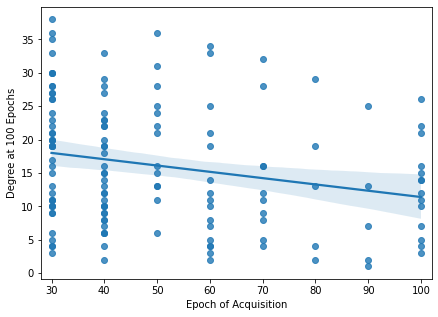

In [173]:
fig = plt.figure(figsize=(7,5), dpi=72)
sns.regplot(data=degree_df, x='t', y='deg')
plt.xlabel('Epoch of Acquisition')
plt.ylabel('Degree at 100 Epochs')
plt.xlim(-.2, 7.2)
plt.xticks([i for i in range(8)], [i * 10 for i in range(3, 11)])
plt.show()

In [174]:
# plt.savefig('reg.eps')

<Figure size 432x288 with 0 Axes>

In [154]:
lm = smf.ols(formula='deg ~ t', data=degree_df).fit()
lm.pvalues

Intercept    2.467975e-36
t            5.114650e-03
dtype: float64

In [155]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    deg   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     8.095
Date:                Mon, 10 May 2021   Prob (F-statistic):            0.00511
Time:                        17:52:49   Log-Likelihood:                -505.00
No. Observations:                 140   AIC:                             1014.
Df Residuals:                     138   BIC:                             1020.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.0000      1.042     17.282      0.000      15.941      20.059
t             -0.9435      0.332     -2.845      0.005      -1.599      -0.288
==============================================================================
Omnibus:                       11.917   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                7.017
Skew:                           0.383   Prob(JB):                       0.0299
Kurtosis:                       2.214   Cond. No.                         4.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
lm.params

Intercept    17.999990
t            -0.943517
dtype: float64

In [22]:
G = nx.Graph()

for (w1, w2) in [(w1, w2) for w1 in tokens for w2 in tokens]:
    try:
        if w1 != w2 and cosine_similarity(wv[w1], wv[w2]) >= 0.4:
            G.add_edge(w1, w2)
    except KeyError:
        continue

for node in G.nodes:
    G.nodes[node]['group'] = nltk.pos_tag([node])[0][1]

In [23]:
## Network attributes
# Get number of nodes
print(G.number_of_nodes())
# Get density
density = nx.density(G)
print("Network density:", density)
# Get degree
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
print(degree_dict)
# Sort by degree
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

48
Network density: 0.07180851063829788
{'good': 1, 'great': 1, 'man': 4, 'mother': 6, 'son': 6, 'father': 6, 'girl': 4, 'sea': 1, 'ocean': 1, 'come': 2, 'got': 5, 'go': 2, 'know': 5, 'thought': 4, 'hey': 5, 'thing': 6, 'family': 4, 'friend': 4, 'witch': 2, 'monkey': 7, 'queen': 2, 'la': 3, 'po': 7, 'li': 7, 'na': 8, 'hyena': 6, 'dog': 3, 'turtle': 3, 'lion': 4, 'wallaby': 4, 'hare': 3, 'said': 1, 'king': 1, 'moment': 2, 'time': 1, 'much': 1, 'little': 3, 'marlin': 2, 'dory': 1, 'one': 1, 'beast': 2, 'ho': 5, 'wa': 4, 'gon': 4, 'fa': 5, 'way': 1, 'xi': 1, 'ha': 1}


In [24]:
# Hierarchy of nodes by degree
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('na', 8)
('monkey', 7)
('po', 7)
('li', 7)
('mother', 6)
('son', 6)
('father', 6)
('thing', 6)
('hyena', 6)
('got', 5)
('know', 5)
('hey', 5)
('ho', 5)
('fa', 5)
('man', 4)
('girl', 4)
('thought', 4)
('family', 4)
('friend', 4)
('lion', 4)


In [25]:
# Don't use
# nx.draw(G, with_labels=True, font_weight='bold')

In [26]:
#Draw network from Networkx graph
nt = Network('2000px', '2000px')
# populates the nodes and edges data structures
nt.from_nx(G)
#nt.
nt.show('G.html')

In [27]:
## Draw network with pyvis
# Creates network based on cosine similarity of words

net = Network('700px', '700px')

# Colors by category
colors = {
    #nouns
    'NN': '#0066CC',
    'NNP': '#0066CC',
    'NNS': '#0066CC',
    'NNPS': '#0066CC',

    #verbs
    'VBG': '#FF0000',
    'VBD': '#FF0000',
    'VB': '#FF0000',
    'VBP': '#FF0000',
    #adjectives
    'JJ': '#FF9933',
    'JJR': '#FF9933',
    'JJS': '#FF9933',
    #function words
    'CC': '#660099',
    # other
    'RB': '#33CC33',
    'IN': '#33CC33',
    'RBR': '#33CC33',
    'RBS': '#33CC33',
    'RB': '#33CC33',
    'CD': '#33CC33',
    'DT': '#33CC33',
    'WDT': '#33CC33',
    'WP': '#33CC33',
    'WRB': '#33CC33',
    'FW': '#33CC33'
}
options = {"node_size": 10, "alpha": 0.3}

for ((w1, t1), (w2, t2)) in [(x, y) for x in tokens for y in tokens]:
    try:
        if w1 != w2 and cosine_similarity(wv[w1], wv[w2]) >= 0.4:
            #tags words by category
            tag = nltk.pos_tag([w1])[0][1]
            net.add_node(w1, color=colors[tag])

            tag = nltk.pos_tag([w2])[0][1]
            net.add_node(w2, color=colors[tag])
            net.add_edge(w1, w2)
    except KeyError:
        continue
#for node in net:
#    net.add_nodes[node]['group'] = nltk.pos_tag([node])[0][1]

ValueError: too many values to unpack (expected 2)

In [28]:
# Export network as html
net.show('30new.html')